# Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
data_dir = '/kaggle/input'
# for dirname, _, filenames in os.walk(data_dir):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
# Lấy địa chỉ của tập dữ liệu

#PATH 30VN FODDS
TRAIN_PATH_30VNFOOD = os.path.join(data_dir, 'vietnamese-foods/Images/Train')
VALIDATE_PATH_30VNFOOD = os.path.join(data_dir, 'vietnamese-foods/Images/Validate')
TEST_PATH_30VNFOOD = os.path.join(data_dir, 'vietnamese-foods/Images/Test')

# PATH CUSTOM FOOD
TRAIN_PATH_CUSTOMFOOD = os.path.join(data_dir, 'custom-food-dataset/FOOD-DATASET/TRAIN')
VALIDATE_PATH_CUSTOMFOOD = os.path.join(data_dir, 'custom-food-dataset/FOOD-DATASET/VAL')
TEST_PATH_CUSTOMFOOD = os.path.join(data_dir, 'custom-food-dataset/FOOD-DATASET/TEST')

# Đọc dữ liệu

In [4]:
# Tạo các Data Frame

def create_dataframe(directory_path):
    """
    Create a DataFrame from image directory
    Args:
        directory_path: Path to image directory
    Returns:
        DataFrame with image paths and labels
    """
    image_paths = []
    labels = []
    
    # Walk through directory
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Get full image path
                image_path = os.path.join(root, file)
                # Get label from parent directory name
                label = os.path.basename(root)
                
                image_paths.append(image_path)
                labels.append(label)
    
    # Create DataFrame
    return pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

In [5]:
# Merge DataFrames
df_train = pd.concat([create_dataframe(TRAIN_PATH_30VNFOOD), create_dataframe(TRAIN_PATH_CUSTOMFOOD)])
df_validate = pd.concat([create_dataframe(VALIDATE_PATH_30VNFOOD), create_dataframe(VALIDATE_PATH_CUSTOMFOOD)])
df_test = pd.concat([create_dataframe(TEST_PATH_30VNFOOD), create_dataframe(TEST_PATH_CUSTOMFOOD)])

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_validate.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Bước 1 : Tìm hiểu tổng quan về bộ dữ liệu

In [6]:
# Get unique labels from training, validation and test sets
train_labels = sorted(df_train['label'].unique())
validate_labels = sorted(df_validate['label'].unique()) 
test_labels = sorted(df_test['label'].unique())

## 1.1 Kiểm tra tính nhất quán của nhãn dữ liệu

In [7]:
# Kiểm tra xem các nhãn có đồng nhất giữa các tập không
if train_labels == validate_labels == test_labels:
    print("Các nhãn đồng nhất giữa các tập")
else:
    print("Cảnh báo: Có sự khác biệt về nhãn giữa các tập!")
    
# Kiểm tra nhãn bị thiếu
all_unique_labels = sorted(set(train_labels + validate_labels + test_labels))
missing_in_train = set(all_unique_labels) - set(train_labels)
missing_in_val = set(all_unique_labels) - set(validate_labels)
missing_in_test = set(all_unique_labels) - set(test_labels)

Các nhãn đồng nhất giữa các tập


## 1.2 Xem số lượng các nhãn dữ liệu

In [8]:
# Print number of unique labels in each set
print(f"Số lượng nhãn trong tập huấn luyện: {len(train_labels)}")
print(f"Số lượng nhãn trong tập kiểm định: {len(validate_labels)}")
print(f"Số lượng nhãn trong tập kiểm tra: {len(test_labels)}")
print(f"Tổng số nhãn dữ liệu trong tập dữ liệu: {len(all_unique_labels)}")

# Print unique labels
print("\nDanh sách nhãn dữ liệu trong tập dữ liệu:")
for i, label in enumerate(all_unique_labels, 1):
    print(f"{i}. {label}")

Số lượng nhãn trong tập huấn luyện: 38
Số lượng nhãn trong tập kiểm định: 38
Số lượng nhãn trong tập kiểm tra: 38
Tổng số nhãn dữ liệu trong tập dữ liệu: 38

Danh sách nhãn dữ liệu trong tập dữ liệu:
1. Banh beo
2. Banh bot loc
3. Banh can
4. Banh canh
5. Banh chung
6. Banh cuon
7. Banh duc
8. Banh gio
9. Banh khot
10. Banh mi
11. Banh pia
12. Banh tet
13. Banh trang nuong
14. Banh xeo
15. Bun bo Hue
16. Bun dau mam tom
17. Bun mam
18. Bun rieu
19. Bun thit nuong
20. Bánh cu đơ
21. Bánh mì cay
22. Bánh đa cua
23. Bánh đậu xanh
24. Bò bía
25. Bún cá
26. Ca kho to
27. Canh chua
28. Cao lau
29. Chao long
30. Com tam
31. Cơm cháy
32. Goi cuon
33. Hu tieu
34. Mi quang
35. Nem chua
36. Nem nướng
37. Pho
38. Xoi xeo


# Bước 2 : Phân tích thống kê cơ bản

## 2.1 Tổng quan về số lượng ảnh các lớp

In [9]:
# Tính số lượng ảnh trung bình mỗi lớp
train_mean = df_train['label'].value_counts().mean()
val_mean = df_validate['label'].value_counts().mean()
test_mean = df_test['label'].value_counts().mean()

print("Số lượng ảnh trung bình mỗi lớp:")
print(f"- Tập huấn luyện: {train_mean:.2f} ảnh/lớp")
print(f"- Tập kiểm định: {val_mean:.2f} ảnh/lớp") 
print(f"- Tập kiểm tra: {test_mean:.2f} ảnh/lớp")

# Tìm nhãn có nhiều ảnh nhất
train_max = df_train['label'].value_counts().idxmax()
val_max = df_validate['label'].value_counts().idxmax()
test_max = df_test['label'].value_counts().idxmax()

print("\nNhãn có nhiều ảnh nhất:")
print(f"- Tập huấn luyện: {train_max} ({df_train['label'].value_counts().max()} ảnh)")
print(f"- Tập kiểm định: {val_max} ({df_validate['label'].value_counts().max()} ảnh)")
print(f"- Tập kiểm tra: {test_max} ({df_test['label'].value_counts().max()} ảnh)")

# Tìm nhãn có ít ảnh nhất
train_min = df_train['label'].value_counts().idxmin()
val_min = df_validate['label'].value_counts().idxmin()
test_min = df_test['label'].value_counts().idxmin()

print("\nNhãn có ít ảnh nhất:")
print(f"- Tập huấn luyện: {train_min} ({df_train['label'].value_counts().min()} ảnh)")
print(f"- Tập kiểm định: {val_min} ({df_validate['label'].value_counts().min()} ảnh)")
print(f"- Tập kiểm tra: {test_min} ({df_test['label'].value_counts().min()} ảnh)")

# Tính tổng số ảnh mỗi tập
train_total = len(df_train)
val_total = len(df_validate)
test_total = len(df_test)

print("\nTổng số ảnh mỗi tập:")
print(f"- Tập huấn luyện: {train_total} ảnh")
print(f"- Tập kiểm định: {val_total} ảnh")
print(f"- Tập kiểm tra: {test_total} ảnh")
print(f"- Tổng cộng: {train_total + val_total + test_total} ảnh")


Số lượng ảnh trung bình mỗi lớp:
- Tập huấn luyện: 492.66 ảnh/lớp
- Tập kiểm định: 72.13 ảnh/lớp
- Tập kiểm tra: 135.95 ảnh/lớp

Nhãn có nhiều ảnh nhất:
- Tập huấn luyện: Bun bo Hue (1071 ảnh)
- Tập kiểm định: Bun bo Hue (153 ảnh)
- Tập kiểm tra: Bun bo Hue (306 ảnh)

Nhãn có ít ảnh nhất:
- Tập huấn luyện: Bánh mì cay (87 ảnh)
- Tập kiểm định: Bánh đa cua (24 ảnh)
- Tập kiểm tra: Bánh mì cay (13 ảnh)

Tổng số ảnh mỗi tập:
- Tập huấn luyện: 18721 ảnh
- Tập kiểm định: 2741 ảnh
- Tập kiểm tra: 5166 ảnh
- Tổng cộng: 26628 ảnh


## 2.2 Phân bố số lượng ảnh theo nhãn dữ liệu

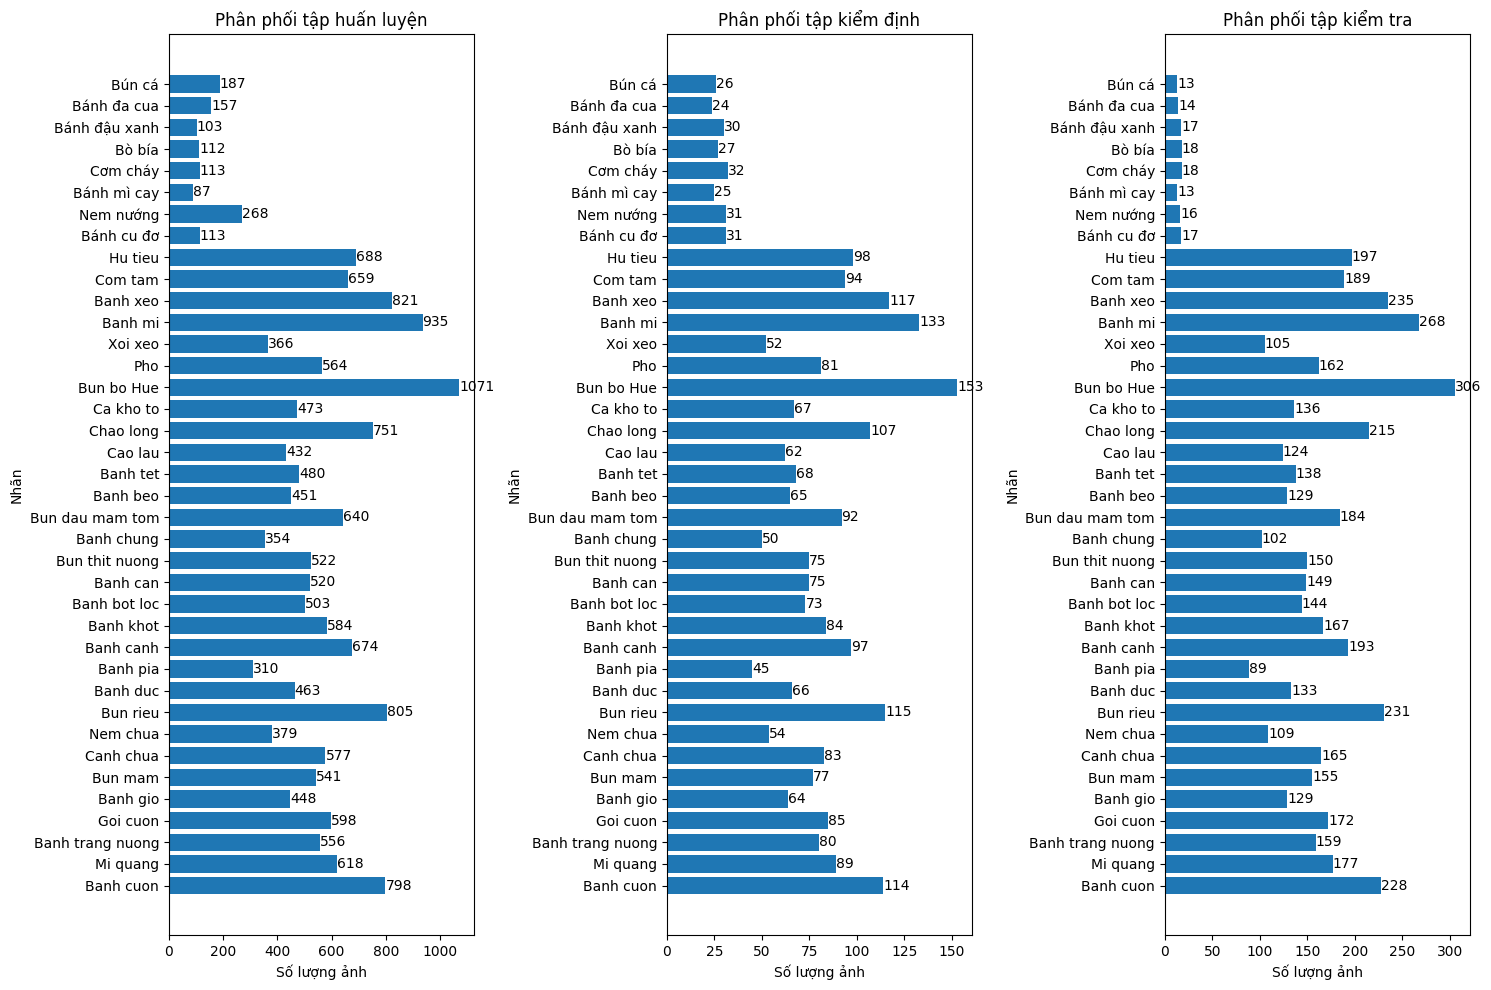

In [10]:
# Vẽ biểu đồ thanh ngang cho phân phối của từng tập
plt.figure(figsize=(15, 10))

# Phân phối tập huấn luyện
plt.subplot(131)
bars = plt.barh(list(df_train['label'].value_counts(sort=False).index), 
                list(df_train['label'].value_counts(sort=False).values))
plt.title('Phân phối tập huấn luyện')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Nhãn')
# Thêm giá trị vào thanh
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

# Phân phối tập kiểm định
plt.subplot(132)
bars = plt.barh(list(df_validate['label'].value_counts(sort=False).index),
                list(df_validate['label'].value_counts(sort=False).values))
plt.title('Phân phối tập kiểm định')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Nhãn')
# Thêm giá trị vào thanh
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

# Phân phối tập kiểm tra
plt.subplot(133)
bars = plt.barh(list(df_test['label'].value_counts(sort=False).index),
                list(df_test['label'].value_counts(sort=False).values))
plt.title('Phân phối tập kiểm tra')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Nhãn')
# Thêm giá trị vào thanh
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

## 2.3 Phân bố tỉ lệ phần trăm ảnh theo nhãn dữ liệu

In [11]:
# Tính phần trăm cho từng nhãn trong tập huấn luyện
train_dist = (df_train['label'].value_counts(sort=False) / df_train['label'].value_counts().sum() * 100).round(2)
val_dist = (df_validate['label'].value_counts(sort=False) / df_validate['label'].value_counts().sum() * 100).round(2)
test_dist = (df_test['label'].value_counts(sort=False) / df_test['label'].value_counts().sum() * 100).round(2)

print("\nPhân phối phần trăm theo nhãn:")
dist_df = pd.DataFrame({
    'Train %': train_dist,
    'Validation %': val_dist,
    'Test %': test_dist
}).iloc[::-1]
print(dist_df)


Phân phối phần trăm theo nhãn:
                  Train %  Validation %  Test %
label                                          
Bún cá               1.00          0.95    0.25
Bánh đa cua          0.84          0.88    0.27
Bánh đậu xanh        0.55          1.09    0.33
Bò bía               0.60          0.99    0.35
Cơm cháy             0.60          1.17    0.35
Bánh mì cay          0.46          0.91    0.25
Nem nướng            1.43          1.13    0.31
Bánh cu đơ           0.60          1.13    0.33
Hu tieu              3.68          3.58    3.81
Com tam              3.52          3.43    3.66
Banh xeo             4.39          4.27    4.55
Banh mi              4.99          4.85    5.19
Xoi xeo              1.96          1.90    2.03
Pho                  3.01          2.96    3.14
Bun bo Hue           5.72          5.58    5.92
Ca kho to            2.53          2.44    2.63
Chao long            4.01          3.90    4.16
Cao lau              2.31          2.26    2.40
Banh tet

## 2.4 Biểu đồ phân bố tỉ lệ ảnh

<Figure size 1500x800 with 0 Axes>

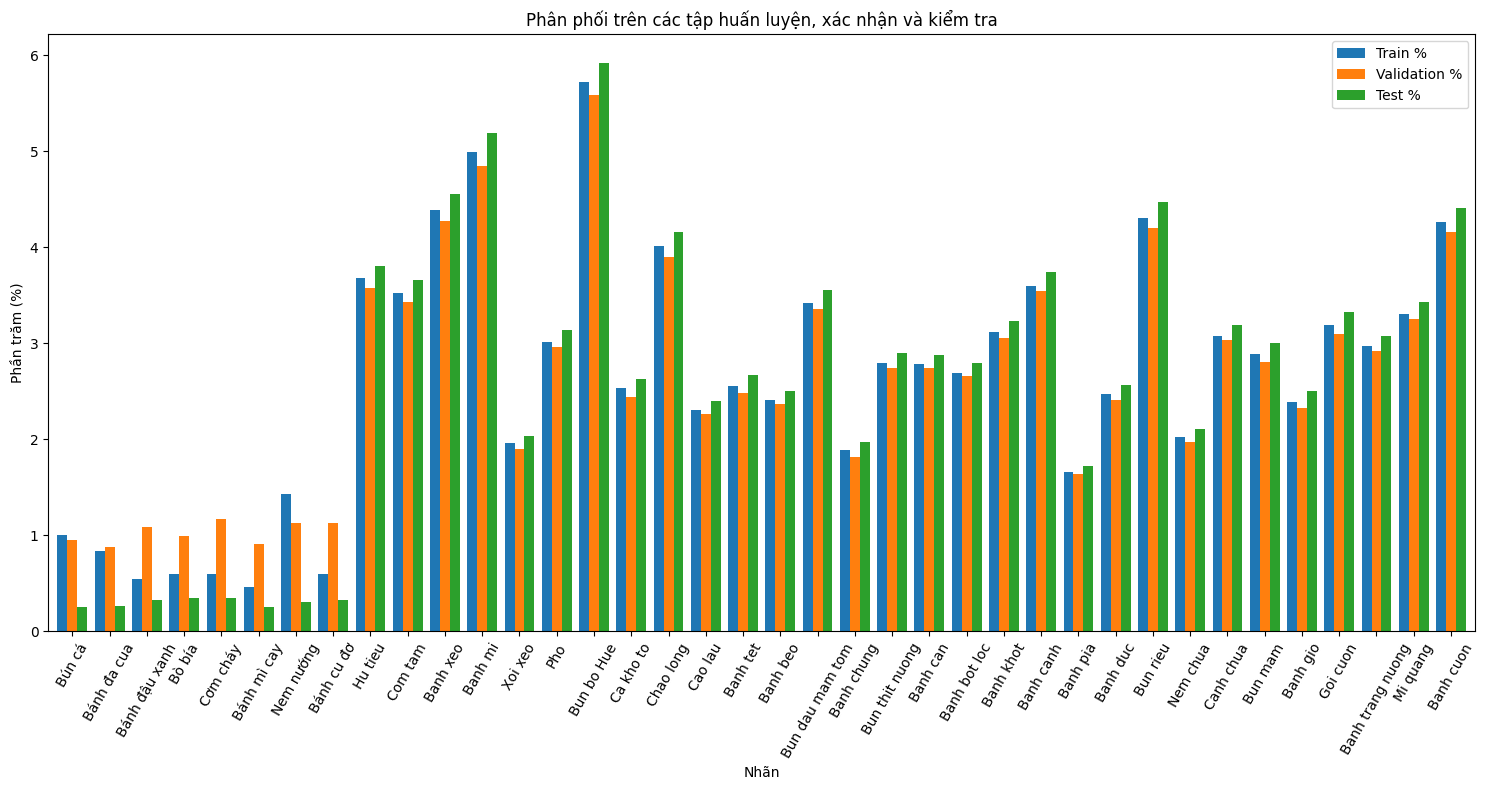

In [12]:
# Plot bar chart showing distribution across all sets
plt.figure(figsize=(15, 8))

# Plot data from dist_df using pandas plotting
ax = dist_df.plot(kind='bar', width=0.8, figsize=(15,8))

plt.xlabel('Nhãn')
plt.ylabel('Phần trăm (%)')
plt.title('Phân phối trên các tập huấn luyện, xác nhận và kiểm tra')
plt.xticks(rotation=60)

plt.legend()
plt.tight_layout()
plt.show()

## 2.5 Đánh giá sự mất cân bằng

In [13]:
# Calculate imbalance metrics
print("Đánh giá sự mất cân bằng dữ liệu:")
print("\n1. Tỷ lệ giữa lớp nhiều nhất và ít nhất:")
max_min_ratio_train = train_dist.max() / train_dist.min()
max_min_ratio_val = val_dist.max() / val_dist.min()
max_min_ratio_test = test_dist.max() / test_dist.min()

print(f"- Tập huấn luyện: {max_min_ratio_train:.2f}")
print(f"- Tập kiểm định: {max_min_ratio_val:.2f}") 
print(f"- Tập kiểm tra: {max_min_ratio_test:.2f}")

print("\n2. Độ lệch chuẩn của phân phối:")
std_train = train_dist.std()
std_val = val_dist.std()
std_test = test_dist.std()

print(f"- Tập huấn luyện: {std_train:.2f}%")
print(f"- Tập kiểm định: {std_val:.2f}%")
print(f"- Tập kiểm tra: {std_test:.2f}%")

print("\n3. Hệ số biến thiên (CV):")
cv_train = (std_train / train_dist.mean()) * 100
cv_val = (std_val / val_dist.mean()) * 100
cv_test = (std_test / test_dist.mean()) * 100

print(f"- Tập huấn luyện: {cv_train:.2f}%")
print(f"- Tập kiểm định: {cv_val:.2f}%")
print(f"- Tập kiểm tra: {cv_test:.2f}%")


Đánh giá sự mất cân bằng dữ liệu:

1. Tỷ lệ giữa lớp nhiều nhất và ít nhất:
- Tập huấn luyện: 12.43
- Tập kiểm định: 6.34
- Tập kiểm tra: 23.68

2. Độ lệch chuẩn của phân phối:
- Tập huấn luyện: 1.29%
- Tập kiểm định: 1.17%
- Tập kiểm tra: 1.49%

3. Hệ số biến thiên (CV):
- Tập huấn luyện: 49.14%
- Tập kiểm định: 44.34%
- Tập kiểm tra: 56.69%


PHÂN TÍCH PHÂN PHỐI DỮ LIỆU CHO THẤY SỰ MẤT CÂN BẰNG NGHIÊM TRỌNG GIỮA CÁC LỚP 😞

NGUYÊN NHÂN: DATASET ĐƯỢC CHIA THÀNH 2 TẬP DỮ LIỆU RIÊNG BIỆT

ĐỀ XUẤT GIẢI PHÁP: SỬ DỤNG KỸ THUẬT OVERSAMPLING ĐỂ CÂN BẰNG DỮ LIỆU:
- XOAY ẢNH
- LẬT ẢNH
- ĐIỀU CHỈNH ĐỘ SÁNG

# Bước 3 : Phân tích chi tiết ảnh

## 3.1 Kiểm tra kích thước ảnh

In [14]:
# Hàm lấy kích thước ảnh
def get_image_size_list(image_path_list):
    sizes = []
    for img_path in tqdm(image_path_list):
        with Image.open(img_path) as img:
            sizes.append(img.size)
    return sizes

# Lấy đường dẫn ảnh cho từng tập
train_image_paths = df_train['image_path'].tolist()
validate_image_paths = df_validate['image_path'].tolist()
test_image_paths = df_test['image_path'].tolist()

# Lấy thông tin kích thước ảnh trong từng tập dữ liệu
train_sizes = get_image_size_list(train_image_paths)
val_sizes = get_image_size_list(validate_image_paths)
test_sizes = get_image_size_list(test_image_paths)

100%|██████████| 5166/5166 [00:30<00:00, 169.21it/s]


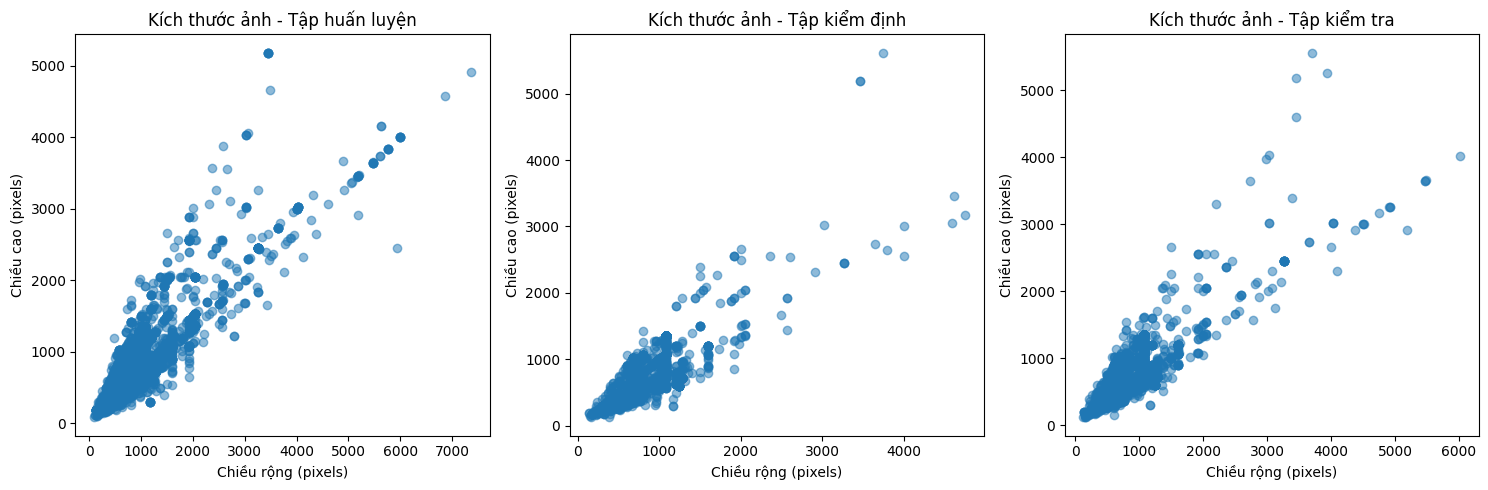


Thống kê kích thước ảnh:

Tập huấn luyện:
Số lượng kích thước khác nhau: 3959
Kích thước phổ biến nhất: (1080, 1080)

Tập kiểm định:
Số lượng kích thước khác nhau: 946
Kích thước phổ biến nhất: (1080, 1080)

Tập kiểm tra:
Số lượng kích thước khác nhau: 1458
Kích thước phổ biến nhất: (1080, 1080)


In [15]:
# Tạo biểu đồ phân phối kích thước ảnh
plt.figure(figsize=(15, 5))

# Biểu đồ cho tập huấn luyện
plt.subplot(1, 3, 1)
widths, heights = zip(*train_sizes)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Kích thước ảnh - Tập huấn luyện')
plt.xlabel('Chiều rộng (pixels)')
plt.ylabel('Chiều cao (pixels)')

# Biểu đồ cho tập kiểm định
plt.subplot(1, 3, 2)
widths, heights = zip(*val_sizes)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Kích thước ảnh - Tập kiểm định')
plt.xlabel('Chiều rộng (pixels)')
plt.ylabel('Chiều cao (pixels)')

# Biểu đồ cho tập kiểm tra
plt.subplot(1, 3, 3)
widths, heights = zip(*test_sizes)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Kích thước ảnh - Tập kiểm tra')
plt.xlabel('Chiều rộng (pixels)')
plt.ylabel('Chiều cao (pixels)')

plt.tight_layout()
plt.show()

# In thống kê kích thước
print("\nThống kê kích thước ảnh:")
print("\nTập huấn luyện:")
print(f"Số lượng kích thước khác nhau: {len(set(train_sizes))}")
print(f"Kích thước phổ biến nhất: {max(set(train_sizes), key=train_sizes.count)}")

print("\nTập kiểm định:")
print(f"Số lượng kích thước khác nhau: {len(set(val_sizes))}")
print(f"Kích thước phổ biến nhất: {max(set(val_sizes), key=val_sizes.count)}")

print("\nTập kiểm tra:")
print(f"Số lượng kích thước khác nhau: {len(set(test_sizes))}")
print(f"Kích thước phổ biến nhất: {max(set(test_sizes), key=test_sizes.count)}")

## 3.2 Kiểm tra tỉ lệ khung hình

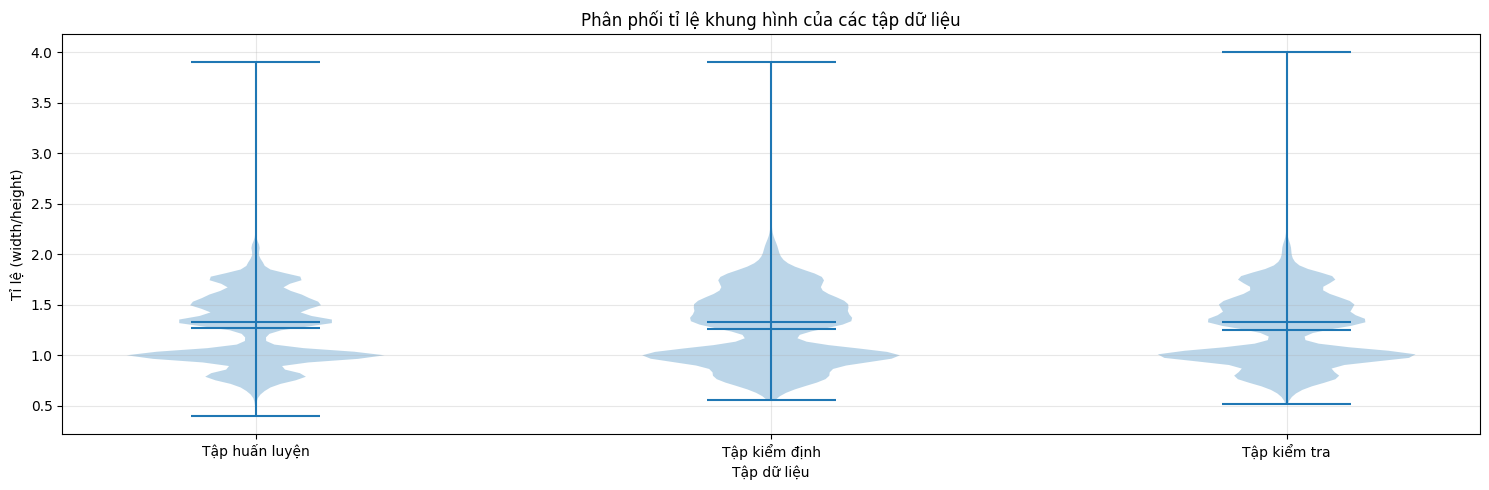


Thống kê tỉ lệ khung hình:

Tập huấn luyện:
Tỉ lệ trung bình: 1.27
Tỉ lệ nhỏ nhất: 0.40
Tỉ lệ lớn nhất: 3.90
Tỉ lệ phổ biến nhất: 1.00

Tập kiểm định:
Tỉ lệ trung bình: 1.27
Tỉ lệ nhỏ nhất: 0.56
Tỉ lệ lớn nhất: 3.90
Tỉ lệ phổ biến nhất: 1.00

Tập kiểm tra:
Tỉ lệ trung bình: 1.25
Tỉ lệ nhỏ nhất: 0.52
Tỉ lệ lớn nhất: 4.00
Tỉ lệ phổ biến nhất: 1.00


In [16]:
# Tính tỉ lệ khung hình (width/height) cho từng tập dữ liệu
train_ratios = [width/height for width, height in train_sizes]
val_ratios = [width/height for width, height in val_sizes]
test_ratios = [width/height for width, height in test_sizes]

# Tạo biểu đồ violin phân phối tỉ lệ khung hình
plt.figure(figsize=(15, 5))

# Chuẩn bị dữ liệu cho biểu đồ violin
data = [train_ratios, val_ratios, test_ratios]
labels = ['Tập huấn luyện', 'Tập kiểm định', 'Tập kiểm tra']

# Vẽ biểu đồ violin
plt.violinplot(data, showmeans=True, showmedians=True)

# Tùy chỉnh trục và nhãn
plt.xticks([1, 2, 3], labels)
plt.title('Phân phối tỉ lệ khung hình của các tập dữ liệu')
plt.xlabel('Tập dữ liệu')
plt.ylabel('Tỉ lệ (width/height)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê tỉ lệ khung hình
print("\nThống kê tỉ lệ khung hình:")
print("\nTập huấn luyện:")
print(f"Tỉ lệ trung bình: {np.mean(train_ratios):.2f}")
print(f"Tỉ lệ nhỏ nhất: {min(train_ratios):.2f}")
print(f"Tỉ lệ lớn nhất: {max(train_ratios):.2f}")
print(f"Tỉ lệ phổ biến nhất: {max(set(train_ratios), key=train_ratios.count):.2f}")

print("\nTập kiểm định:")
print(f"Tỉ lệ trung bình: {np.mean(val_ratios):.2f}")
print(f"Tỉ lệ nhỏ nhất: {min(val_ratios):.2f}")
print(f"Tỉ lệ lớn nhất: {max(val_ratios):.2f}")
print(f"Tỉ lệ phổ biến nhất: {max(set(val_ratios), key=val_ratios.count):.2f}")

print("\nTập kiểm tra:")
print(f"Tỉ lệ trung bình: {np.mean(test_ratios):.2f}")
print(f"Tỉ lệ nhỏ nhất: {min(test_ratios):.2f}")
print(f"Tỉ lệ lớn nhất: {max(test_ratios):.2f}")
print(f"Tỉ lệ phổ biến nhất: {max(set(test_ratios), key=test_ratios.count):.2f}")


## 3.3 Kiểm tra độ sắc nét - Phát hiện ảnh mờ

 82%|████████▏ | 15416/18721 [05:20<01:42, 32.25it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
100%|██████████| 18721/18721 [06:24<00:00, 48.64it/s] 


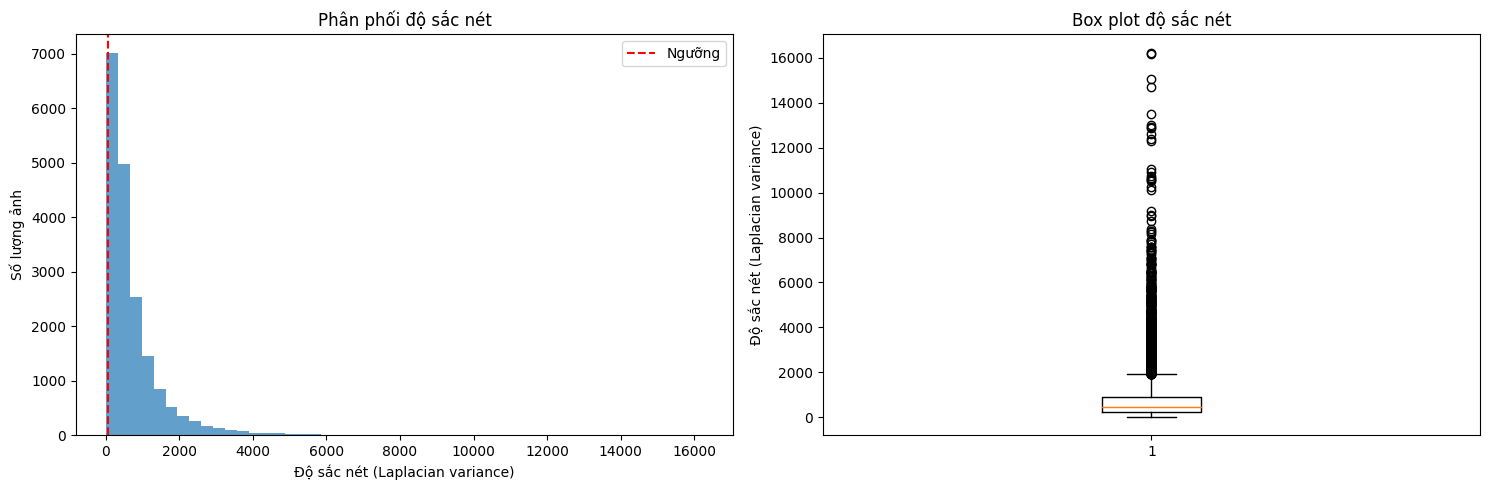


Tổng số ảnh: 18720
Số ảnh mờ: 553 (2.95%)
Số ảnh sắc nét: 18167 (97.05%)

Hiển thị một số ví dụ ảnh mờ:


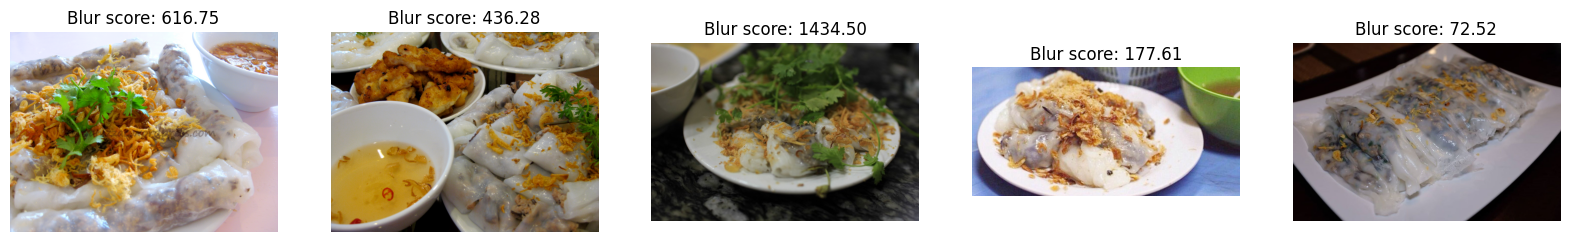

In [19]:
def detect_blur_images(image_paths, threshold=100):
    """
    Phát hiện và phân tích độ sắc nét của ảnh
    Args:
        image_paths: Danh sách đường dẫn ảnh
        threshold: Ngưỡng để xác định ảnh mờ (default: 100)
    """
    # Khởi tạo danh sách lưu kết quả
    blur_scores = []
    blur_images = []
    sharp_images = []
    
    # Tính toán độ sắc nét cho từng ảnh
    for img_path in tqdm(image_paths):
        try:
            # Đọc ảnh
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            # Chuyển sang ảnh xám
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Tính độ sắc nét sử dụng Laplacian
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            blur_scores.append(laplacian_var)
            
            # Phân loại ảnh dựa trên ngưỡng
            if laplacian_var < threshold:
                blur_images.append(img_path)
            else:
                sharp_images.append(img_path)
                
        except Exception as e:
            print(f"Lỗi xử lý ảnh {img_path}: {str(e)}")
            
    # Vẽ biểu đồ phân phối độ sắc nét
    plt.figure(figsize=(15, 5))
    
    # Histogram độ sắc nét
    plt.subplot(1, 2, 1)
    plt.hist(blur_scores, bins=50, alpha=0.7)
    plt.axvline(x=threshold, color='r', linestyle='--', label='Ngưỡng')
    plt.title('Phân phối độ sắc nét')
    plt.xlabel('Độ sắc nét (Laplacian variance)')
    plt.ylabel('Số lượng ảnh')
    plt.legend()
    
    # Box plot độ sắc nét
    plt.subplot(1, 2, 2)
    plt.boxplot(blur_scores)
    plt.title('Box plot độ sắc nét')
    plt.ylabel('Độ sắc nét (Laplacian variance)')
    
    plt.tight_layout()
    plt.show()
    
    # In thống kê
    print(f"\nTổng số ảnh: {len(blur_scores)}")
    print(f"Số ảnh mờ: {len(blur_images)} ({len(blur_images)/len(blur_scores)*100:.2f}%)")
    print(f"Số ảnh sắc nét: {len(sharp_images)} ({len(sharp_images)/len(blur_scores)*100:.2f}%)")
    
    # Hiển thị một số ví dụ ảnh mờ
    print("\nHiển thị một số ví dụ ảnh mờ:")
    n_examples = min(5, len(blur_images))
    plt.figure(figsize=(20, 4))
    for i in range(n_examples):
        plt.subplot(1, n_examples, i+1)
        img = cv2.imread(blur_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f'Blur score: {blur_scores[i]:.2f}')
        plt.axis('off')
    plt.show()
    
    return blur_scores, blur_images, sharp_images

# Sử dụng hàm
blur_scores, blur_images, sharp_images = detect_blur_images(
    df_train['image_path'].tolist(),
    threshold=50
)